In [47]:
# Modify the simulation to include **User Participation Decision** based on Cost-Benefit Tradeoff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to Calculate Privacy Sensitivity Score from Data Preferences Statements
def calculate_privacy_sensitivity(statements, mode="papaya"):
    """
    Computes privacy sensitivity scores dynamically.
    """

    privacy_scores = {}
    for statement in statements:
        anonymization = statement["A"]
        platform = statement["P"]
        purposes = statement["R"]

        sensitivity_score = 0.5
        if anonymization == "Anonymized":
            sensitivity_score += 0.3  
        else:
            sensitivity_score -= 0.3  

        sensitivity_score -= 0.05 * len(purposes)  
        if platform == "Advertisers":
            sensitivity_score += 0.2  

        sensitivity_score = max(0, min(1, sensitivity_score))
        for purpose in purposes:
            privacy_scores[(platform, purpose, anonymization)] = sensitivity_score

    return privacy_scores


# Define Privacy Cost Function
def calculate_privacy_cost(platform, purpose, anonymization):
    """
    Assigns a privacy cost for a given (P, R, A) tuple.
    - Advertisers have higher privacy cost.
    - De-anonymized data has higher privacy cost.
    - More invasive purposes (Targeted Ads) have higher privacy cost.
    """
    base_cost = 0.3 if anonymization == "Anonymized" else 0.6  # Higher cost for de-anonymized data

    if platform == "Advertisers":
        base_cost += 0.2  # Advertisers have higher privacy cost

    if purpose in ["Targeted Ads", "Email Marketing"]:
        base_cost += 0.1  # These purposes are more invasive

    return min(1, base_cost)  # Cap privacy cost at 1


# Define User Class with Cost-Benefit Participation Decision
class User:
    def __init__(self, user_id, statements, mode="papaya"):
        self.user_id = user_id
        self.statements = statements  
        self.privacy_sensitivity = calculate_privacy_sensitivity(statements, mode)
        self.earnings = 0

    def get_relevant_statements(self, platform_type):
        return [s for s in self.statements if s["P"] == platform_type]

    def get_privacy_sensitivity(self, platform, purpose, anonymization):
        return self.privacy_sensitivity.get((platform, purpose, anonymization), 0.5)

    def will_participate(self, platform, purpose, anonymization, price):
        """Users only participate if expected earnings outweigh privacy cost."""
        privacy_cost = calculate_privacy_cost(platform, purpose, anonymization)
        return price >= privacy_cost


# Define Platform Class with Profitability Factors (δR)
class Platform:
    def __init__(self, platform_type, budget, value_per_purpose, profitability_factors, mode="papaya"):
        self.platform_type = platform_type
        self.budget = budget
        self.value_per_purpose = value_per_purpose
        self.profitability_factors = profitability_factors
        self.mode = mode  

    def bid_for_data(self, purpose, anonymization, user_privacy_sensitivity):
        if purpose not in self.value_per_purpose:
            return 0  

        base_value = self.value_per_purpose[purpose]
        profitability_factor = self.profitability_factors.get(purpose, 1.0)

        if self.mode == "ipdm":
            return min(base_value, self.budget)  

        price = base_value * profitability_factor * (1 - user_privacy_sensitivity)
        price = price if anonymization == "De-anonymized" else price * 0.8  # Reduce penalty on anonymized data

        return min(price, self.budget)


# Define Broker Class with Data Union Effect (only in Papaya Market)
class Broker:
    def __init__(self, commission_rate=0.1, mode="papaya"):
        self.commission_rate = commission_rate  
        self.union_factor = {}  
        self.mode = mode  

    def process_transactions(self, users, platforms):
        total_transactions = 0
        earnings_data = []

        self.union_factor.clear()

        if self.mode == "papaya":
            for user in users:
                for statement in user.statements:
                    key = (statement["P"], tuple(statement["R"]), statement["A"])
                    self.union_factor[key] = self.union_factor.get(key, 0) + 1

        for user in users:
            for platform in platforms:
                user_statements = user.get_relevant_statements(platform.platform_type)
                for statement in user_statements:
                    if self.mode == "papaya":
                        purposes = statement["R"]
                        anonymity = statement["A"]
                    else :
                        purposes = ["Targeted Ads", "Email Marketing", "Market Research", "Product Recommendation"]
                        anonymity = "De-anonymized"
                    for purpose in purposes:
                        privacy_sensitivity = user.get_privacy_sensitivity(platform.platform_type, purpose, anonymity)
                        price = platform.bid_for_data(purpose, anonymity, privacy_sensitivity)
                        if price > 0 and (self.mode == "ipdm" or user.will_participate(platform.platform_type, purpose, anonymity, price)):
                            if self.mode == "papaya":
                                union_multiplier = 1 + (self.union_factor[(platform.platform_type, tuple(statement["R"]), statement["A"])] * 0.1)
                                price *= union_multiplier

                            payout = price * (1 - self.commission_rate)
                            user.earnings += payout  
                            platform.budget -= price
                            total_transactions += 1
                            privacy_cost = calculate_privacy_cost(platform.platform_type, purpose, anonymity)

                            earnings_data.append({
                                "User_ID": user.user_id,
                                "Platform": platform.platform_type,
                                "Purpose": purpose,
                                "Anonymization": statement["A"],
                                "Privacy Sensitivity": privacy_sensitivity,
                                "Privacy Cost": privacy_cost,
                                "Union Effect": union_multiplier if self.mode == "papaya" else 1,
                                "Earnings": payout,
                                "Market": self.mode
                            })

        return total_transactions, earnings_data


# Initialize platforms
platforms_ipdm = [
    Platform("Advertisers", budget=5000, value_per_purpose={"Targeted Ads": 50, "Email Marketing": 30},
             profitability_factors={"Targeted Ads": 1.2, "Email Marketing": 1.0}, mode="ipdm"),
    Platform("Retailers", budget=4000, value_per_purpose={"Market Research": 40, "Product Recommendation": 25},
             profitability_factors={"Market Research": 1.1, "Product Recommendation": 0.9}, mode="ipdm"),
]

platforms_papaya = [
    Platform("Advertisers", budget=5000, value_per_purpose={"Targeted Ads": 50, "Email Marketing": 30},
             profitability_factors={"Targeted Ads": 1.2, "Email Marketing": 1.0}, mode="papaya"),
    Platform("Retailers", budget=4000, value_per_purpose={"Market Research": 40, "Product Recommendation": 25},
             profitability_factors={"Market Research": 1.1, "Product Recommendation": 0.9}, mode="papaya"),
]

# Make users
# Generate 100 users with randomized privacy preferences for both IPDM and Papaya Market

import random

def generate_random_statements():
    """Generates a user with random (P, R, A) preferences."""
    anonymization_choices = ["Anonymized", "De-anonymized"]
    platform_choices = ["Advertisers", "Retailers"]
    purpose_choices = ["Targeted Ads", "Email Marketing", "Market Research", "Product Recommendation"]

    statements = []
    num_statements = random.randint(1, 3)  # Each user can have 1-3 preference statements

    for _ in range(num_statements):
        selected_purposes = random.sample(purpose_choices, random.randint(1, len(purpose_choices)))  # Random # of purposes
        statements.append({
            "A": random.choice(anonymization_choices),
            "P": random.choice(platform_choices),
            "R": selected_purposes
        })

    return statements

users_ipdm = []
users_papaya = []

for i in range(1, 101):
    statements = generate_random_statements()
    users_ipdm.append(User(i, statements, mode="ipdm"))
    users_papaya.append(User(i, statements, mode="papaya"))


# Initialize brokers
broker_ipdm = Broker(commission_rate=0.1, mode="ipdm")
broker_papaya = Broker(commission_rate=0.1, mode="papaya")

# Run simulations
NUM_ROUNDS = 10
all_earnings_data = []

for round in range(NUM_ROUNDS):
    transactions_ipdm, earnings_ipdm = broker_ipdm.process_transactions(users_ipdm, platforms_ipdm)
    transactions_papaya, earnings_papaya = broker_papaya.process_transactions(users_papaya, platforms_papaya)

    all_earnings_data.extend(earnings_ipdm)
    all_earnings_data.extend(earnings_papaya)

# Convert results to a DataFrame and display
df = pd.DataFrame(all_earnings_data)

In [48]:
df

,User_ID,Platform,Purpose,Anonymization,Privacy Sensitivity,Privacy Cost,Union Effect,Earnings,Market
0,1,Advertisers,Targeted Ads,Anonymized,0.20,0.9,1.0,45.000,ipdm
1,1,Advertisers,Email Marketing,Anonymized,0.20,0.9,1.0,27.000,ipdm
2,1,Advertisers,Targeted Ads,De-anonymized,0.20,0.9,1.0,45.000,ipdm
3,1,Advertisers,Email Marketing,De-anonymized,0.20,0.9,1.0,27.000,ipdm
4,1,Retailers,Market Research,Anonymized,0.50,0.6,1.0,36.000,ipdm
...,...,...,...,...,...,...,...,...,...
619,87,Advertisers,Targeted Ads,Anonymized,0.85,0.6,1.1,7.128,papaya
620,89,Advertisers,Email Marketing,De-anonymized,0.30,0.9,1.3,24.570,papaya
621,93,Advertisers,Email Marketing,Anonymized,0.85,0.6,1.1,3.564,papaya
622,93,Advertisers,Targeted Ads,Anonymized,0.85,0.6,1.1,7.128,papaya


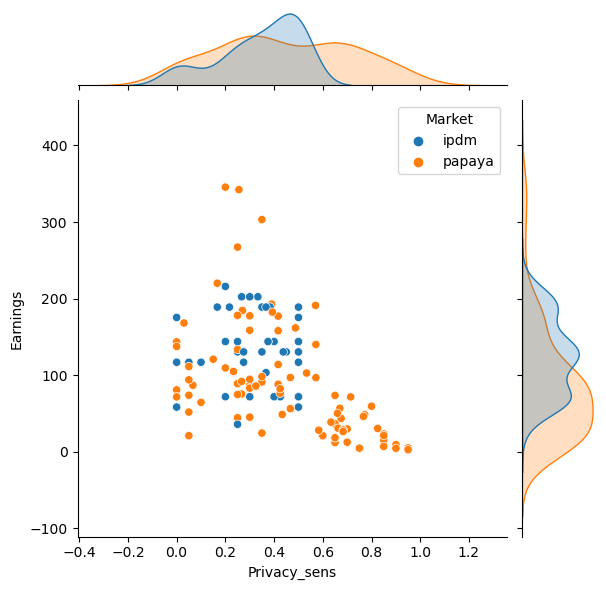

In [49]:
df_earnings_privacy = df.groupby(["User_ID", "Market"]).agg(
    Earnings=("Earnings", "sum"), 
    Privacy_sens=("Privacy Sensitivity", "mean")
).reset_index()

#df_earnings_privacy
sns.jointplot(data = df_earnings_privacy, x = "Privacy_sens", y = "Earnings", hue = "Market");

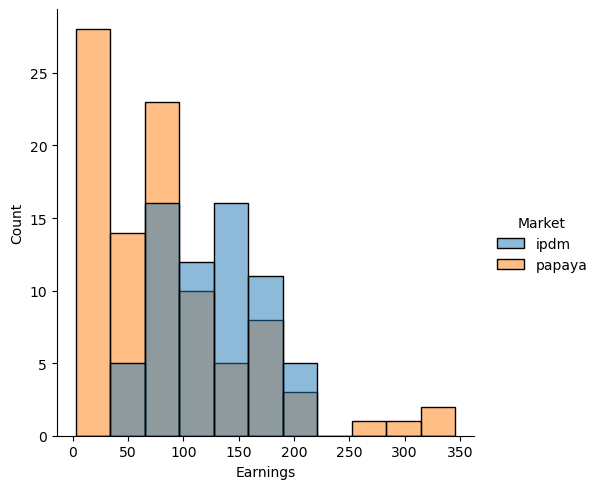

In [50]:
sns.displot(data = df_earnings_privacy, x = "Earnings", hue = "Market");

In [51]:
# Calculate Social Welfare for Each Market (IPDM vs Papaya)
# Social Welfare = Sum of Earnings + Remaining Platform Budgets

# Aggregate earnings by market
df["EarningsPC"] = df["Earnings"] * (1 - df["Privacy Cost"])
earningspc_by_market = df.groupby("Market")["EarningsPC"].sum()

# Calculate remaining platform budgets for each market
remaining_budget_ipdm = sum(platform.budget for platform in platforms_ipdm)
remaining_budget_papaya = sum(platform.budget for platform in platforms_papaya)

# Compute social welfare
social_welfare = {
    "IPDM": earningspc_by_market["ipdm"] + remaining_budget_ipdm,
    "Papaya Market": earningspc_by_market["papaya"] + remaining_budget_papaya
}

# Convert results to a DataFrame and display
social_welfare_df = pd.DataFrame.from_dict(social_welfare, orient="index", columns=["Social Welfare"])

social_welfare_df


,Social Welfare
IPDM,1890.000000
Papaya Market,2285.884192


<AxesSubplot:xlabel='Market'>

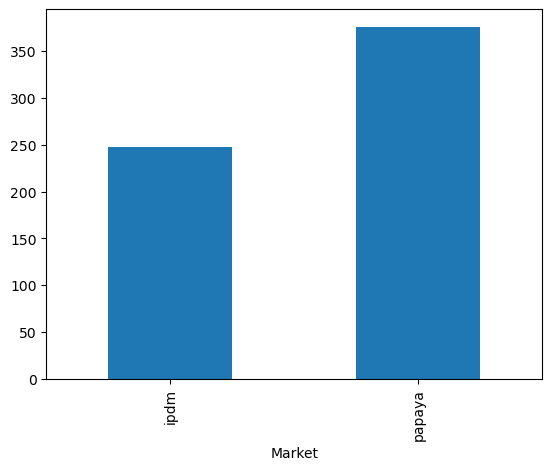

In [52]:
df.groupby("Market")["User_ID"].count().plot(kind="bar")


In [53]:
df[df["Market"] == "papaya"]["Privacy Cost"].mean()

0.6239361702127659

In [54]:
df.groupby("Market")["Earnings"].agg(["mean", "std", "median"])


,mean,std,median
Market,,,
ipdm,32.661290,8.634984,33.75000
papaya,21.556418,16.105275,21.16125
